In [1]:
clean_up = True
%run stdPackages.ipynb
ws = gams.GamsWorkspace(working_directory=d['work']) # specify where you want to run the GAMS models from (here the repository referred to in d['work'])
d['data'] = os.path.join(d['data'], 'IO2018')

The file _gams_py_gdb0.gdx is still active and was not deleted.
The file _gams_py_gdb1.gdx is still active and was not deleted.


## SmallGR, households

### Data/settings

Load std. data, settings:

In [2]:
name = 'smallGR' # name of model
module = name+'_HH' # name of module
db_IO = GpyDB(pickle_path = os.path.join(d['data'], f'IO_{name}')) # load IO database named IO_name
with open(f"{d['data']}\\glob_{name}","rb") as file: # load global settings anmed glob_name
    glob=pickle.load(file)
dataFile = os.path.join(d['data'],'smallGR_Households.xlsx')

Beyond the standard IO data, we load relevant data on regulation for households:

In [3]:
regulation = read.SeriesDB_from_wb(dataFile, {'variables': ['regulation']})
Tree = nestingTree.aggTree_from_data(dataFile, read_trees = {'consumption': {'name': f'{module}_ces', 'f':'CES'}}, name = module)()

Define labor tax rate:

In [4]:
tLabor = (regulation.get('vTaxAggregate').xs('laborTax',level='taxAggregate') / db_IO.get('qS').xs('L',level='n'))[0]
gpyDB.add_or_merge_vals(db_IO, pd.Series(tLabor, index = pd.MultiIndex.from_tuples([('HH','L')], names = ['s','n'])), 'tauS')

Define $\tau_D$ as the flat ```VAT``` rate from IO data:

In [5]:
tVAT = pd.Series(db_IO.get('vTax').xs(('HH','Moms'))/db_IO.get('qD').xs('HH').sum(), index = adj.rc_pd(db_IO.get('qD'), Tree.get('s')).index, name = 'tauD')
gpyDB.add_or_merge_vals(db_IO, tVAT, 'tauD')

Add level on lump-sum tax directly from regulation data:

In [6]:
gpyDB.add_or_merge_vals(db_IO, regulation.get('vTaxAggregate').xs('tauLump',level='taxAggregate'),'tauLump')

Adjust the ```TotalTax``` from the household sector based on this new way:

In [7]:
gpyDB.add_or_merge_vals(db_IO, regulation.get('vTaxAggregate').groupby('s').sum()+db_IO.get('vTax').xs(('HH','Moms')), 'TotalTax')

Export adjusted IO data again:

In [8]:
db_IO.export(repo=d['data'])

### Nesting

For now, assume a simple nested utility function where all goods first compete against their foreign counterpart (```x,x_F```) and second that these aggregates are combined in a simple CES nest as the aggregate ```C```. These are already loaded to the ```Tree``` in the data part.

In an upper nest consumption and labor is combined with a constant frisch elasticity of labor. We specify the symbols with a simple mapping ```L2C```:

In [9]:
L2C = pd.MultiIndex.from_tuples([('HH','L','C')], names = ['s','n','nn'])

Add time index to the IO data:

In [10]:
def addT(symbol, t):
    return adjMultiIndex.bc(symbol, t).reorder_levels(['t']+symbol.index.names if 't' not in symbol.index.names else symbol.index.names)
[db_IO.__setitem__(k, addT(db_IO.get(k), glob.db['t'].vals)) for k in db_IO.getTypes(['variable','scalar_variable'])];

### Initialize module

*Initialize module without any savings first (static method):*

In [11]:
H = CGE_Households.SimpleRamsey(tree = Tree, glob = glob, kwargs = {'L2C': L2C}) # init module
aggregateDB.subset_db(db_IO, H.get('s')) # Keep data on relevant sectors
aggregateDB.subset_db(db_IO, H.get('n')) # Keep data on relevant goods
# robust.robust_merge_dbs(H.s.db, db_IO, priority = 'second') # Merge IO data into the database of the module; if a symbol is in both, prioritize records from the second database

*Value shares for nesting part:*

In [12]:
v = valueShares.SimpleRamsey(Tree, db_IO.copy())
v.compile() # set up model structure, and make sure to initialize symbols if they are not yet defined in the database 
v.write(); # write GAMS code used for the model
m = v.run(exportTo = d['work'],ws=ws) # solve the "model".

Use value shares to initialize variables:
* Outputs and inputs are provided by IO data.
* For intermediate goods, assume a price of 1 (default option in the class, so we don't have to do anything) and set value share = quantity.
* Set share parameters to the ones identified by value share system.

In [13]:
gpyDB.GpyDBs_AOM_Second(H.s.db, gpy(adj.rc_pd(m.out_db.get('vD'), H.get('int')).rename('qD'))) # set intermediate goods levels
gpyDB.GpyDBs_AOM_Second(H.s.db, gpy(m.out_db.get('mu').xs(H.get('t0')[0]).rename('mu'))) # set share parameters
H.s.db['a'] = db_IO.get('a')

Add the frisch parameter as a target in the IO database:

In [14]:
db_IO['frisch'] = pd.Series(0.25, index = H.get('labor'), name = 'frisch')

Use sneaky calibration method to solve and calibrate:

In [15]:
H.compile(initDB=True)
H.write();
mCalib, cp = H.sneakyCalib(db_IO, ws = ws, loop_kwargs = {'n': 10}, **{'cns': 'CONOPT4'})

Inspect how assets evolve over time:

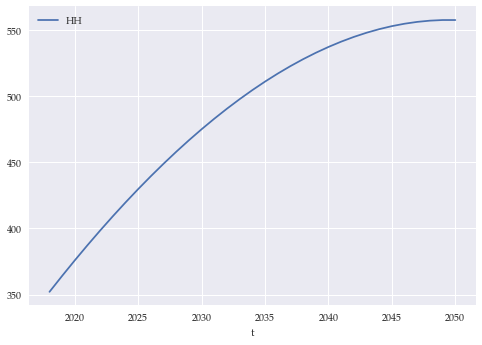

In [16]:
mCalib.out_db.get('vAssets').unstack('s').xs('total',level='a').plot(subplots=True, backend="matplotlib");

### 5. Export 

*Use data from the calibration step in the main database. The ```sneakyCalib``` method defines some new, auxiliary symbols - these are not used.*

In [18]:
[gpyDB.GpyDBs_AOM_Second(H.s.db, mCalib.out_db[k]) for k in H.s.db.symbols];
H.s.setstate('B')

Export:

In [19]:
with open(os.path.join(d['data'], H.name), "wb") as file:
    pickle.dump(H,file)